<a href="https://colab.research.google.com/github/Radical-Ghost/C/blob/main/Food_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 94.0 MB/s eta 0:00:00


# **Imports**

In [33]:
# import system libs
import os
import shutil
import random
import imghdr
from pathlib import Path
from timeit import default_timer as timer

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

#  import Deep learning Libraries
import torch
from torch.export import export
from torch import nn
import torch.utils.data.dataloader
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
import torchvision

#exporting model
import torch.onnx

#ignoring Waenings
import warnings
warnings.filterwarnings("ignore")

In [19]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Pre-requisites for Kaggle import

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ra1dical","key":"112e44f5ebe218557c6c58fa21a7f0e7"}'}

In [5]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Data**

In [6]:
!kaggle datasets download harishkumardatalab/food-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0
 99% 1.67G/1.68G [00:21<00:00, 88.8MB/s]
100% 1.68G/1.68G [00:21<00:00, 84.4MB/s]


In [7]:
!unzip food-image-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food Classification dataset/idli/277.jpg  
  inflating: Food Classification dataset/idli/278.jpg  
  inflating: Food Classification dataset/idli/280.jpg  
  inflating: Food Classification dataset/idli/282.jpg  
  inflating: Food Classification dataset/idli/283.jpg  
  inflating: Food Classification dataset/idli/284.jpg  
  inflating: Food Classification dataset/idli/285.jpg  
  inflating: Food Classification dataset/idli/286.jpg  
  inflating: Food Classification dataset/idli/287.jpg  
  inflating: Food Classification dataset/idli/288.jpg  
  inflating: Food Classification dataset/idli/290.jpg  
  inflating: Food Classification dataset/idli/292.jpg  
  inflating: Food Classification dataset/idli/293.jpg  
  inflating: Food Classification dataset/idli/295.jpg  
  inflating: Food Classification dataset/idli/296.jpg  
  inflating: Food Classification dataset/idli/297.jpg  
  inflating: Food Classification dataset/idli/299.jpg

# **Pre-processing**


1.   Dividing DataSet

In [11]:
main_folder = "/content/Food Classification dataset"
train_folder = 'train'
test_folder = 'test'

In [13]:
# Percentage of images to be allocated for testing
test_percentage = 20

# Iterate through each subfolder in the main folder
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        num_images = len(images)
        num_test_images = int(num_images * (test_percentage / 100))

        # Create train and test folders for the current subfolder
        train_subfolder = os.path.join(train_folder, folder_name)
        test_subfolder = os.path.join(test_folder, folder_name)
        os.makedirs(train_subfolder, exist_ok=True)
        os.makedirs(test_subfolder, exist_ok=True)

        # Randomly select images for the test set
        test_images = random.sample(images, num_test_images)

        # Move images to their respective folders
        for image in images:
            image_path = os.path.join(folder_path, image)
            if image in test_images:
                shutil.move(image_path, os.path.join(test_subfolder, image))
            else:
                shutil.move(image_path, os.path.join(train_subfolder, image))

Images separated into train and test sets successfully!



2.   creating dataloader



In [15]:
NUM_WORKERS = 4
def create_dataloaders(
    train_dir:str,
    test_dir:str,
    train_transforms:transforms.Compose,
    test_transforms:transforms.Compose,
    batch_size:int,
    num_workers:int=NUM_WORKERS
):
    #select all image and implement selected transform and turn into tensor
    train_data=datasets.ImageFolder(train_dir,transform=train_transforms)
    test_data=datasets.ImageFolder(test_dir,transform=test_transforms)

    class_names=train_data.classes

    train_dataloader=DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader,test_dataloader,class_names

In [16]:
data_path=Path()
train_dir=data_path / "train"
test_dir=data_path / "test"

weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms=weights.transforms()

train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=train_dir,
                                                                          test_dir=test_dir,
                                                                          train_transforms=auto_transforms,
                                                                          test_transforms=auto_transforms,
                                                                          batch_size=32)

#  **DefiningModel**

In [20]:
model=torchvision.models.efficientnet_b0(weights=weights)

for param in model.features.parameters():
    param.requires_grad=False

model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names)
)).to(device)

In [21]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

# **Training of Model**

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch,(image,label) in enumerate(data_loader):
        image,label=image.to(device),label.to(device)
        y_pred=model(image)
        loss=loss_fn(y_pred,label)
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc +=(y_pred_class==label).sum().item()/len(y_pred)

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device =device):
    test_loss,test_acc=0,0

    model.eval()
    with torch.inference_mode():
        for batch,(image,label) in enumerate(data_loader):
            image,label=image.to(device),label.to(device)
            test_pred_logits=model(image)
            loss=loss_fn(test_pred_logits,label)
            test_loss += loss.item()
            test_pred_labels=test_pred_logits.argmax(dim=1)
            test_acc+= ((test_pred_labels==label).sum().item()/len(test_pred_labels))

        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
    return test_loss,test_acc

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
          epochs:int=5,
          device=device):

    results={"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
        test_loss,test_acc=test_step(model=model,
                                       data_loader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        print(f"Epoch:{epoch}| train_loss:{train_loss:.4f}|train_acc:{train_acc:.4f}|test_loss:{test_loss:.4f}|test_acc:{test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results


In [24]:
start_time=timer()
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
results=train(model=model.cuda(),
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0| train_loss:0.8443|train_acc:0.7666|test_loss:0.8461|test_acc:0.7614
Epoch:1| train_loss:0.8191|train_acc:0.7595|test_loss:0.7655|test_acc:0.7803
Epoch:2| train_loss:0.7522|train_acc:0.7757|test_loss:0.7637|test_acc:0.7811
Epoch:3| train_loss:0.7169|train_acc:0.7851|test_loss:0.7498|test_acc:0.7759
Epoch:4| train_loss:0.6841|train_acc:0.7903|test_loss:0.7259|test_acc:0.7877
[INFO]Total training time= 1364.983 seconds


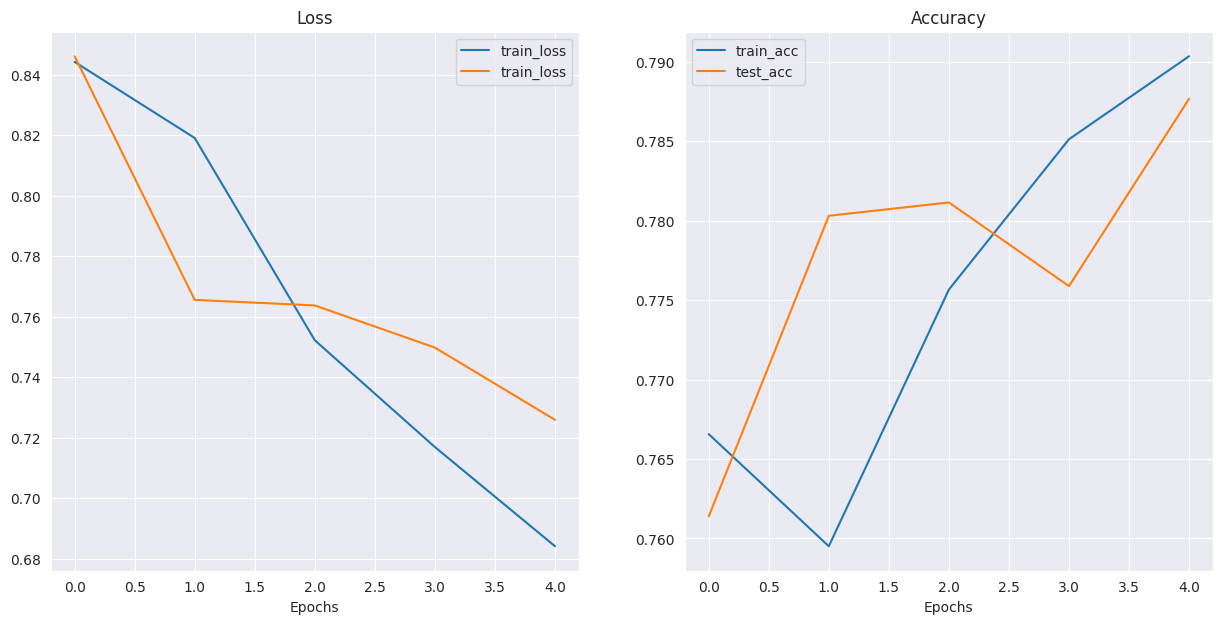

In [26]:
def plot_loss_curves(results):
    loss=results["train_loss"]
    test_loss=results["test_loss"]

    accuracy=results["train_acc"]
    test_accuracy=results["test_acc"]
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label="train_loss")
    plt.plot(epochs,test_loss,label="train_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy,label="train_acc")
    plt.plot(epochs,test_accuracy,label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(results)

In [28]:
torch.save(model, 'model_complete.pth')

In [30]:
dummy_input = torch.randn(1, 3, 224, 224, device="cuda")

In [36]:
torch.onnx.export(
    model,                            # The model to be exported
    dummy_input,                      # A dummy input to specify the input shape
    "model.onnx",                     # Output file path
    export_params=True,               # Store the trained parameter weights inside the model file
    opset_version=11,                 # ONNX version (opset)
    do_constant_folding=True,         # Whether to execute constant folding for optimization
    input_names=["input"],            # The model's input names
    output_names=["output"],          # The model's output names
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

![image.png](attachment:665ccbd6-d135-441d-a853-5da9e9c47785.png)

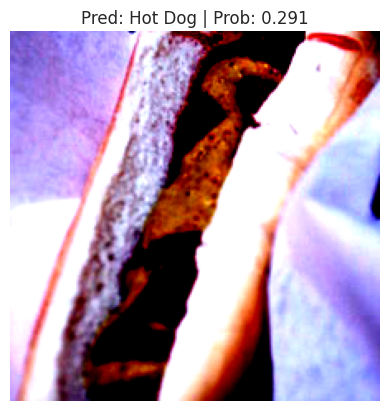

In [39]:
#we will do a single prediction
def pred_and_plot_image(
    model:torch.nn.Module,
    image_path:str,
    class_names:List[str]=None,
    transform=None,
    device=device):

    target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image =target_image /255

    if transform:
        target_image=transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image=target_image.unsqueeze(0)

        target_image_pred=model(target_image.to(device))

        target_image_pred_probs=torch.softmax(target_image_pred,dim=1)

        target_image_pred_labels=torch.argmax(target_image_pred_probs,dim=1)

        plt.imshow(target_image.squeeze().permute(1,2,0))
        if class_names:
            title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else:
            title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        plt.title(title)
        plt.axis(False)

pred_and_plot_image(model=model,
                    image_path="/content/139177.jpg",
                    class_names=class_names,
                    transform=auto_transforms,
                    device=device)